In [31]:
from tqdm import tqdm
import random
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from rdkit import DataStructs
from rdkit.Chem import PandasTools, AllChem
from rdkit import Chem
from rdkit.Chem import Descriptors

In [2]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)

seed_everything(42) # Seed 고정

In [3]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
test

,ID,Smiles
0,TEST_000,O=C(C1=CSC(C2=CC=CN=C2)=N1)NC3=CC(NC4CCN(C)CC4...
1,TEST_001,N#CC1=CC(C=C2)=C(C=C1)N2C(N=C3)=NC(NC4CCCCC4)=...
2,TEST_002,N#CC(C=C1)=C(N[C@@H]2CCNC2)C=C1NC(N=C3)=NC=C3C...
3,TEST_003,N#CC(C=C1)=CC=C1NC(N=C2)=NC(NC3CC(NC(C=C)=O)CC...
4,TEST_004,N#CC(C=C1)=CC=C1NC(N=C2)=NC(NC3CC(N)CC3)=C2C(C...
...,...,...
108,TEST_108,N#CC1=CC(C=C2)=C(C=C1)N2C(N=C3)=NC(N4CCOCC4)=C...
109,TEST_109,O=C(C1=CSC(C2=CC=NC=C2)=N1)NC3=CC(NC4CCN(C(C)C...
110,TEST_110,N#Cc1ccc(Nc2ncc(cn2)c3cnn(c3)C4CCNCC4)cc1N[C@@...
111,TEST_111,O=C(C)N(CC1)CCC1N2N=CC(C3=CN=C(N4C(C=CC(C#N)=C...


In [8]:
import shutil
import os

# 캐시 디렉토리 경로
cache_dir = os.path.expanduser("~/.cache/huggingface/transformers/")

# 캐시 디렉토리 삭제
if os.path.exists(cache_dir):
    shutil.rmtree(cache_dir)
    print(f"Cache directory {cache_dir} has been deleted.")
else:
    print("Cache directory does not exist.")


Cache directory does not exist.


In [12]:
from transformers import RobertaTokenizer, RobertaModel

# ChemBERTa 모델과 토크나이저를 로드합니다.
model_name = "seyonec/ChemBERTa-zinc-base-v1"  # ChemBERTa 모델 이름
tokenizer = RobertaTokenizer.from_pretrained(model_name)
model = RobertaModel.from_pretrained(model_name)

# SMILES 문자열을 처리할 준비가 되었습니다.


vocab.json:   0%|          | 0.00/9.43k [00:00<?, ?B/s]

C:\Users\User\anaconda3\envs\project\lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\User\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


merges.txt:   0%|          | 0.00/3.21k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/166 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/501 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/179M [00:00<?, ?B/s]

Some weights of the model checkpoint at seyonec/ChemBERTa-zinc-base-v1 were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
import torch

smiles_list = train["Smiles"].tolist()

def encode_smiles(smiles, tokenizer, model):
    # SMILES 문자열을 토크나이즈
    inputs = tokenizer(smiles, return_tensors="pt", padding=True, truncation=True)

    # 모델을 통해 임베딩 생성
    with torch.no_grad():
        outputs = model(**inputs)

    # [CLS] 토큰의 임베딩 추출
    return outputs.last_hidden_state[:, 0, :].numpy()

# 예시 SMILES 문자열
# smiles_example = "CCO"

# SMILES 문자열을 임베딩으로 변환
embedding = [encode_smiles(s, tokenizer, model) for s in tqdm(smiles_list)]
print(embedding)


100%|██████████████████████████████████████████████████████████████████████████████| 1952/1952 [03:23<00:00,  9.61it/s]
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [28]:
# pd.DataFrame([embedding[i][0] for i in range(len(embedding))]).to_csv('./embedding.csv')

In [30]:
pd.read_csv('./embedding.csv',index_col=0)

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,1.814627,-0.084419,-1.058477,-1.628465,-0.466700,-1.507859,-0.842441,0.335402,-0.283067,-0.423362,...,0.620246,0.321733,1.646836,-1.482431,0.528601,-0.246298,-0.747290,-0.481679,-0.110391,0.716317
1,1.666182,-0.503268,0.626425,-0.206483,0.288581,-0.612760,-0.201019,-0.248511,0.436149,0.200204,...,0.633546,0.306340,0.705140,-1.889774,0.739700,-0.659527,-0.358650,-0.699178,-1.506277,0.425109
2,1.571358,-0.404264,0.614413,-0.241252,0.073735,-0.390676,-0.461483,-0.418293,0.187083,-0.051071,...,0.690399,0.331613,0.563577,-2.093349,0.729987,-0.926859,-0.640506,-0.818735,-1.528884,0.335939
3,2.433464,-0.132200,0.405979,-0.223709,0.598900,-1.092515,0.189733,0.004495,0.307354,0.273779,...,1.252353,-0.088294,0.820866,-1.871548,0.607930,-0.603906,-1.089435,-0.203224,-1.244117,0.748164
4,0.915030,0.183558,-0.748636,-0.771476,-0.699415,-1.580822,-0.460932,0.430770,-0.947052,-1.353960,...,1.002815,-0.177607,1.443263,-1.340694,-0.334272,-0.067151,-0.683490,-1.049965,-0.552362,0.592290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1947,1.779955,-0.284961,-0.014995,-1.540478,-0.406378,0.226145,-0.079376,-1.144427,-0.823113,0.146707,...,1.176599,-0.471363,0.405269,-0.233940,0.326091,1.219205,-0.804716,-0.666126,-0.408221,0.976949
1948,0.919610,0.005144,0.901334,-0.908764,0.535593,0.366368,0.073855,-1.115044,1.317449,-0.452602,...,0.697948,0.756857,0.539947,0.297744,-0.364302,1.192122,-1.238316,-0.046343,-1.235196,1.130862
1949,1.681720,0.199867,-0.293458,-0.237783,0.312796,0.103573,-0.053071,-1.074580,-0.842852,-0.387691,...,1.150811,0.080472,-0.292527,0.110778,0.416592,0.858883,-1.053711,0.092585,-0.594632,0.775866
1950,1.802201,1.254986,0.016763,-1.893431,-0.759595,-1.001664,-0.102764,-0.053458,-1.644632,0.412419,...,0.734403,-0.647561,1.797414,-1.532430,1.605065,-1.063572,-0.589564,0.239726,-1.364433,-0.203039


In [32]:
train

,Molecule ChEMBL ID,Standard Type,Standard Relation,Standard Value,Standard Units,pChEMBL Value,Assay ChEMBL ID,Target ChEMBL ID,Target Name,Target Organism,Target Type,Document ChEMBL ID,IC50_nM,pIC50,Smiles
0,CHEMBL4443947,IC50,'=',0.022,nM,10.66,CHEMBL4361896,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4359855,0.022,10.66,CN[C@@H](C)C(=O)N[C@H](C(=O)N1C[C@@H](NC(=O)CC...
1,CHEMBL4556091,IC50,'=',0.026,nM,10.59,CHEMBL4345131,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4342485,0.026,10.59,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...
2,CHEMBL4566431,IC50,'=',0.078,nM,10.11,CHEMBL4345131,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4342485,0.078,10.11,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...
3,CHEMBL4545898,IC50,'=',0.081,nM,10.09,CHEMBL4345131,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4342485,0.081,10.09,CC(C)(O)[C@H](F)CN1Cc2cc(NC(=O)c3cnn4cccnc34)c...
4,CHEMBL4448950,IC50,'=',0.099,nM,10.00,CHEMBL4361896,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL4359855,0.099,10.00,COc1cc2c(OC[C@@H]3CCC(=O)N3)ncc(C#CCCCCCCCCCCC...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1947,CHEMBL380009,IC50,'=',30000.000,nM,4.52,CHEMBL870864,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL1147720,30000.000,4.52,O=C(Nc1nc2cc[nH]cc-2n1)c1cccc([N+](=O)[O-])c1
1948,CHEMBL377654,IC50,'=',30000.000,nM,4.52,CHEMBL870864,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL1147720,30000.000,4.52,CCCCn1c(NC(=O)c2cccc(Cl)c2)nc2ccccc21
1949,CHEMBL208667,IC50,'=',30000.000,nM,4.52,CHEMBL870864,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL1147720,30000.000,4.52,O=C(Nc1nc2cc(F)c(F)cc2[nH]1)c1cccc([N+](=O)[O-...
1950,CHEMBL3403453,IC50,'=',42000.000,nM,4.38,CHEMBL3407004,CHEMBL3778,Interleukin-1 receptor-associated kinase 4,Homo sapiens,SINGLE PROTEIN,CHEMBL3400143,42000.000,4.38,OC[C@H]1C[C@@H](Nc2nc(Nc3ccccc3)ncc2-c2nc3cccc...


In [33]:
train['Molecular_Weight'] = [Descriptors.MolWt(Chem.MolFromSmiles(i)) for i in train['Smiles']]
train['Numbond'] = [Chem.MolFromSmiles(i).GetNumBonds() for i in train['Smiles']]
train['HeavyAtoms'] = [Chem.MolFromSmiles(i).GetNumHeavyAtoms() for i in train['Smiles']]
train['AlogP'] = [Descriptors.MolLogP(Chem.MolFromSmiles(i)) for i in train['Smiles']]


C:\Users\User\AppData\Local\Temp\ipykernel_7836\288942379.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['IC50_nM'].value_counts())


<Axes: xlabel='IC50_nM', ylabel='Density'>

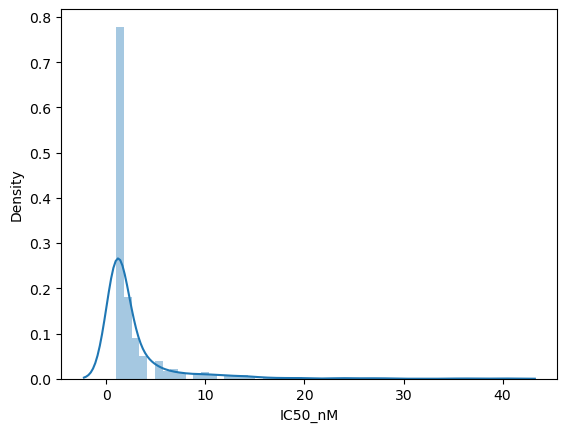

In [39]:
import seaborn as sns

sns.distplot(train['IC50_nM'].value_counts())